## Import Dependencies 

In [49]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry
import os
import glob
from tqdm import tqdm
from astropy.time import Time
from datetime import timedelta
import matplotlib.dates as mdates
import time as tm
import datetime

# Setup
Select the folder where the images are kept.

In [50]:
Star_Name = 'DY Pegasi'
Comp_Star_Name = 'HD 218587'

test_image = fits.open('../data/HAT-P-22/images/_DCM0001.NEF_bin2x2_aligned.fit')

image_folder = '../data/HAT-P-22/images/'
file_pattern = '_DCM*.NEF_bin2x2_aligned.fit' 

star_x, star_y = 1718.5, 1031.6
comp_x, comp_y = 2225.2, 1330.1



positions = [(star_x, star_y) , (comp_x, comp_y)]

aperture_radius = 20
annuli_inner = 25
annuli_outer = 35

bias_files = ['../data/HAT-P-22/calibration frames/_DCM9870_bias.NEF.fits','../data/HAT-P-22/calibration frames/_DCM9871_bias.NEF.fits']

graph_folder = '../graphs'

fits_files = []
search_path = os.path.join(image_folder, file_pattern)
fits_files = sorted(glob.glob(search_path))
image_length=len(fits_files)
print(image_length)

1


## Load Test Image
To make sure the images are working and valid.

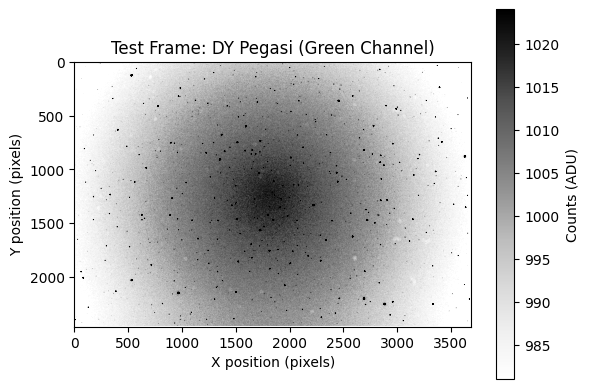

In [51]:
test_image_data = test_image[0].data
test_image_data = test_image_data[1,:,:]
plt.figure()
plt.imshow(test_image_data, 
           vmin=np.percentile(test_image_data, 10), 
           vmax=np.percentile(test_image_data, 99),
           #norm = LogNorm(), 
           cmap='Greys')

plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
cbar = plt.colorbar()
cbar.set_label('Counts (ADU)')
plt.title(f'Test Frame: {Star_Name} (Green Channel)')

plt.savefig(f'../graphs/{Star_Name}-Test_image.png', dpi=300, bbox_inches='tight')
plt.show()


## Zoomed in Section

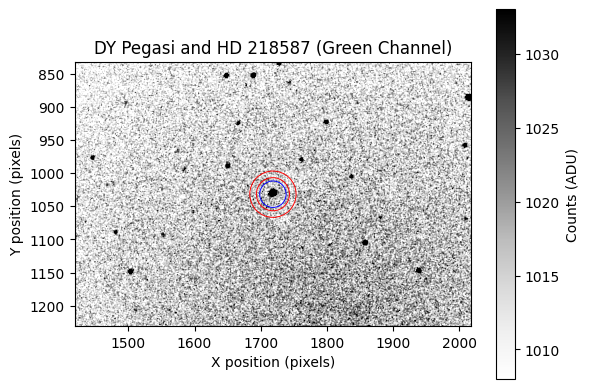

In [52]:
zoom_height = 400
zoom_width = zoom_height * 1.5
section_ymin, section_ymax = (star_y - zoom_height/2), (star_y + zoom_height/2)
section_xmin, section_xmax = (star_x - zoom_width/2), (star_x + zoom_width/2)
section = test_image_data[int(section_ymin):int(section_ymax), int(section_xmin):int(section_xmax)]

apertures = CircularAperture(positions, r=aperture_radius)
annuli = CircularAnnulus(positions, r_in=annuli_inner, r_out=annuli_outer)

plt.imshow(test_image_data, vmin=np.percentile(section, 10), vmax=np.percentile(section, 99), cmap='Greys')
apertures.plot(color = 'blue', lw = .7, alpha = 1);
annuli.plot(color = 'red', lw = .7, alpha = 1);
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')
cbar = plt.colorbar()
cbar.set_label('Counts (ADU)')
plt.title(f'{Star_Name} and {Comp_Star_Name} (Green Channel)')


plt.xlim(section_xmin,section_xmax)
plt.ylim(section_ymax,section_ymin)
plt.savefig(f'../graphs/{Star_Name}-Zoomed_Image.png', dpi=300, bbox_inches='tight')



## Image Analysis

### Photometry Method
$$
C_{\text{obj}}=C_{\text{aper}}-C_{\text{sky}}=C_{\text{aper}}-N_{\text{aper}}\left( \frac{C_{\text{annul}}}{N_{\text{annul}}}  \right)
$$
$C_{\text{obj}} =\text{Counts of Object}$, $\quad C_{\text{aper}} =\text{Counts in aperture}$, $\quad C_{\text{sky}} =\text{Background sky count}$, $\quad C_{\text{annul}} =\text{Counts in annulus}$, $\quad N_{\text{aper}} =\text{Pixels in aperture}$, $\quad N_{\text{annul}} =\text{Pixels in annulus}$


In [17]:
times = []
C_target = []
C_comp = []
C_target_sky = []
C_comp_sky = []

for i, filename in tqdm(enumerate(fits_files), total=len(fits_files)):
    with fits.open(filename) as open_file:
        #again only loads green channel
        data = open_file[0].data[1, :, :].astype(np.float32)
        time = open_file[0].header['DATE-OBS']   
        t_obj = Time(time, format='isot', scale='utc')

    phot_table = aperture_photometry(data, [apertures, annuli])

    C_aper = phot_table['aperture_sum_0'] 
    C_annul = phot_table['aperture_sum_1'] 
    N_aper = apertures.area
    N_annul = annuli.area 

    C_sky = N_aper * (C_annul/N_annul)
    C_obj = C_aper - C_sky

    

    C_target.append(C_obj[0])
    C_comp.append(C_obj[1])

    C_target_sky.append(C_sky[0])
    C_comp_sky.append(C_sky[1])

    times.append(t_obj.mjd)

    
utc_array = np.array(times)
target_counts = np.array(C_target)
comp_counts = np.array(C_comp)
target_sky_counts = np.array(C_target_sky)
comp_sky_counts = np.array(C_comp_sky)

100%|█████████████████████████████████████████| 126/126 [01:06<00:00,  1.90it/s]


## Saving/Loading Data
#### Saving

In [18]:
save_dir = f'../data/{Star_Name}/light_curves'
os.makedirs(save_dir, exist_ok=True)
save_filename = f'{Star_Name}_lightcurve-{Comp_Star_Name}-r_{aperture_radius}-rin_{annuli_inner}-rout_{annuli_outer}-n_{image_length}.npz'
full_save_path = os.path.join(save_dir, save_filename)

np.savez(full_save_path, 
        target=target_counts, 
        comp=comp_counts, 
        time=utc_array,
        target_sky = target_sky_counts,
        comp_sky = comp_sky_counts
        )
        
print(f'saved {save_filename}')

saved DY Pegasi_lightcurve-HD 218587-r_15-rin_25-rout_35-n_126.npz


#### Loading

In [25]:
load_filename = 'DY Pegasi_lightcurve-HD 218587-r_15-rin_25-rout_35-n_126.npz' #save_filename
#set the above value to 'save_filename' for default

loaded_data = np.load(f'../data/{Star_Name}/light_curves/{load_filename}')
target_counts = loaded_data['target']
comp_counts = loaded_data['comp']
utc_array = loaded_data['time']
target_sky_counts = loaded_data['target_sky']
comp_sky_counts = loaded_data['comp_sky']

## Pre Plotting Step
### Something
Normalizing and calculating relative flux.
Change timezone of time data.
Mask data if needed.
Define transit start and end.

In [26]:
t_obj_array = Time(utc_array, format='mjd')
utc_datetime = t_obj_array.to_datetime()
pst_datetime = utc_datetime - timedelta(hours = 8)

sort_indices = np.argsort(t_obj_array)

target_counts = target_counts[sort_indices]
comp_counts = comp_counts[sort_indices]
pst_datetime = pst_datetime[sort_indices]
target_sky_counts = target_sky_counts[sort_indices]
comp_sky_counts = comp_sky_counts[sort_indices]



time_limit = datetime.datetime(2025, 12, 30, 4, 20, 18) 

mask = [t < time_limit for t in pst_datetime] 

target_counts = target_counts[mask]
comp_counts = comp_counts[mask]
pst_datetime = pst_datetime[mask]
target_sky_counts = target_sky_counts[mask]
comp_sky_counts = comp_sky_counts[mask]

relative_flux = target_counts / comp_counts

normalized_flux = target_counts / np.median(target_counts)
normalized_comp = comp_counts / np.median(comp_counts)
normalized_relative_flux = relative_flux / np.median(relative_flux)

transit_start = 20451.993055555555
transit_end = 20452.10347222222

### Error Analysis
Lecture Symbol,"Library Output (e.g., photutils)",Meaning

Caper​ ,`aperture_sum`,Total light in the inner circle

Cannul​,`annulus_sum`,Total light in the outer ring

Naper​,`aperture_area`,Area of inner circle (pixels)

Nannul​,`annulus_area`,Area of outer ring (pixels)

$$\text{Noise} = \sqrt{C_\text{obj}+C_{\text{sky}} + C_\text{dark}+N_\text{aper}\sigma_\text{ron}^2}$$
$C_\text{obj}$ is `target_counts`

$C_\text{sky} = \frac{\text{annulus sum}}{\text{annulus area}}*\text{aperture area}$

$C_\text{dark} \approx 0$

$\text{Read}$ calculated from 

$$
C_{\text{obj}}=C_{\text{aper}}-C_{\text{sky}}=C_{\text{aper}}-N_{\text{aper}}\left( \frac{C_{\text{annul}}}{N_{\text{annul}}}  \right)
$$

#### Calculating Read Noise
Load two bias frames. The two frames are subtracted from each other to eliminate the random noise present. The standard deviation of the difference is the read noise.
$$
\sigma_\text{diff} = \sqrt{2} \times \sigma _\text{ron} \implies \sigma _\text{ron} = \frac{\sigma_\text{diff}}{\sqrt{2}}
$$

In [23]:
gain = 1.4

bias_1 = fits.getdata(bias_files[0]).astype(np.float64) 
bias_2 = fits.getdata(bias_files[1]).astype(np.float64)

std_diff = np.std(bias_1 - bias_2)

read_noise = std_diff / np.sqrt(2)


target_noise = np.sqrt(gain*target_counts + gain*target_sky_counts + 0 + N_aper*(gain*read_noise)**2)
comp_noise = np.sqrt(gain*comp_counts + gain*comp_sky_counts + 0 + N_aper*(gain*read_noise)**2)


#Normalizing to plot
normalized_flux_err = (target_noise/gain) / np.median(target_counts)
normalized_comp_err = (comp_noise/gain) / np.median(comp_counts) 
relative_noise = np.sqrt(np.abs(((target_counts + (target_noise/gain))/ comp_counts)-relative_flux)**2 + np.abs(((target_counts)/(comp_counts + (comp_noise/gain)))-relative_flux)**2)
normalized_relative_flux_err = relative_noise/ np.median(relative_flux)

## Plot

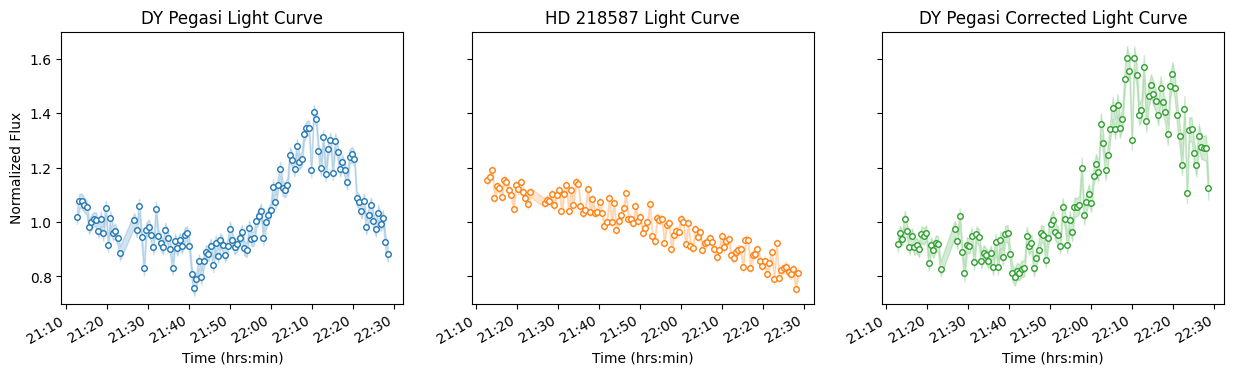

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

ax1.fill_between(pst_datetime, normalized_flux - normalized_flux_err, normalized_flux + normalized_flux_err, color='tab:blue', alpha=0.2, label='Uncertainty')
ax1.errorbar(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=4, color='tab:blue', linestyle='None',
            #yerr = normalized_flux_err, capsize = 2, elinewidth = 1,
            )
ax1.set_title(f'{Star_Name} Light Curve')



ax2.fill_between(pst_datetime, normalized_comp - normalized_comp_err, normalized_comp + normalized_comp_err, color='tab:orange', alpha=0.2, label='Uncertainty')
ax2.errorbar(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=4, color='tab:orange', linestyle='None',
            #yerr = normalized_comp_err, capsize = 2, elinewidth = 1,
            )
ax2.set_title(f'{Comp_Star_Name} Light Curve')



ax3.fill_between(pst_datetime, normalized_relative_flux - normalized_relative_flux_err, normalized_relative_flux + normalized_relative_flux_err, color='tab:green', alpha=0.2, label='Uncertainty')
ax3.errorbar(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=4, color='tab:green', linestyle='None',
            #yerr = normalized_relative_flux_err, capsize = 2, elinewidth = 1,
            )
ax3.set_title(f'{Star_Name} Corrected Light Curve')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0.7, 1.7)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    #ax.axvline(x=transit_end, color='red', linestyle='--', alpha=0.7,)
    #ax.axvline(x=transit_start, color='red', linestyle='--', alpha=0.7, label='Transit Start/End')
    
    ax.set_xlabel('Time (hrs:min)')
    if ax == ax1:
        ax.set_ylabel('Normalized Flux') 
    #ax.legend(fontsize = 6)

fig.autofmt_xdate()

plt.savefig(f'../graphs/{Star_Name}-Light_Curves.png', dpi=300, bbox_inches='tight')

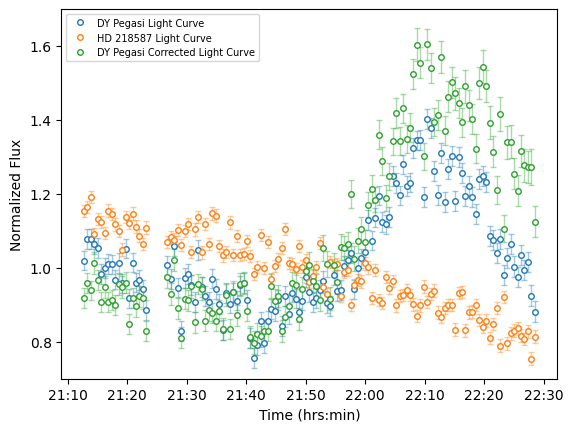

In [43]:
plt.figure()

ax1.set_title(f'{Star_Name} Light Curve')
ax2.set_title(f'{Comp_Star_Name} Light Curve')
ax3.set_title(f'{Star_Name} Corrected Light Curve')

plt.fill_between(pst_datetime, normalized_comp - normalized_comp_err, normalized_comp + normalized_comp_err, color='tab:orange', alpha=0.2, label=f'{Comp_Star_Name} Uncertainty')
plt.fill_between(pst_datetime, normalized_flux - normalized_flux_err, normalized_flux + normalized_flux_err, color='tab:blue', alpha=0.2, label=f'{Star_Name} Uncertainty')
plt.fill_between(pst_datetime, normalized_relative_flux - normalized_relative_flux_err, normalized_relative_flux + normalized_relative_flux_err, color='tab:green', alpha=0.2, label=f'{Star_Name} Corrected Uncertainty')

plt.errorbar(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=0, color='tab:blue', linestyle='None',
            yerr = normalized_flux_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )
plt.errorbar(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=0, color='tab:orange', linestyle='None',
            yerr = normalized_comp_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )
plt.errorbar(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=0, color='tab:green', linestyle='None',
            yerr = normalized_relative_flux_err, capsize = 2, elinewidth = 1, alpha = 0.4
            )

#plt.plot(pst_datetime, normalized_flux, marker='o', mfc='white', markersize=4, color='tab:blue', linestyle='None', label = f'{Star_Name} Light Curve')
#plt.plot(pst_datetime, normalized_comp, marker='o', mfc='white', markersize=4, color='tab:orange', linestyle='None', label = f'{Comp_Star_Name} Light Curve')
#plt.plot(pst_datetime, normalized_relative_flux, marker='o', mfc='white', markersize=4, color='tab:green', linestyle='None', label = f'{Star_Name} Corrected Light Curve')



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim(0.7, 1.7)
plt.xlabel('Time (hrs:min)')
plt.ylabel('Normalized Flux')

plt.legend(fontsize=7)
plt.savefig(f'../graphs/{Star_Name}-Combined-Light_Curves.png', dpi=300, bbox_inches='tight')
plt.show()